# Garbage Classification CNN


## Prerequisites

### If you are trying to run this Jupyter notebook then, please have cloned from my GitLab
 - As it contains the required Kaggle dataset
 - And my own defined prediction dataset that is required to run this notebook
 


## (0) Required imports

In [1]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from math import floor
import matplotlib.pyplot as plt

os.chdir("Garbage classification/")

## (1) Pre-processing of the images
- Read in 6 folders and a prediction folder
- Give each folder of differing images an output class
- Put into a correct numpy array format
- Normalise RGB values to between 0 and 1

In [2]:
optimisedModel = True # Boolean to switch between image augmentation/dropout and without

In [3]:
dataset = []
predictionDataset = []
highResPredictionDataset = []
imageCounts = []

# Change into the Garbage classification folder
for label, imageFolders in enumerate(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', 'predictions']):
    os.chdir(imageFolders)
    
    imageList = os.listdir()

    for numberCount, image in enumerate(imageList):
        # Open the current image
        currentImage = Image.open(image)
        imageName = (currentImage.filename).split('.')[0]

        if imageFolders == "predictions":
            # Add high resolution image
            currentImage = np.array(currentImage)   
            currentImage = currentImage / 255.0
            highResPredictionDataset.append(currentImage)
            
            # Add low resolution image
            currentImage = Image.open(image)
            imageName = (currentImage.filename).split('.')[0]

             ## Resize the image by 50%
            currentImage = currentImage.resize((32, 32), Image.ANTIALIAS)

             # Normalise the image between 0 and 1
            currentImage = np.array(currentImage)   
            currentImage = currentImage / 255.0
            predictionDataset.append((currentImage, imageName))
            
        else:
            ## Resize the image by 50%
            currentImage = currentImage.resize((32, 32), Image.ANTIALIAS)

             # Normalise the image between 0 and 1
            currentImage = np.array(currentImage)   
            currentImage = currentImage / 255.0

            # Add the currentImage and 6 modifications to the currentImage
            dataset.append((currentImage, label))
        
    # Go back a directory
    os.chdir("../")
    
    # Get the current count for each folder
    if imageFolders != "predictions":
        imageCounts.append(numberCount+1)
    
os.chdir("../")

# Randomly shuffle the dataset
random.shuffle(dataset)

### Plotting a bar graph of the number of images in the dataset

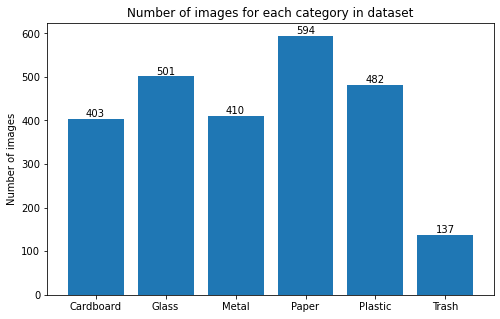

In [4]:
fig = plt.figure(figsize=(8, 5))
categories = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
plt.bar(categories, imageCounts)
locs, _ = plt.xticks()

# Add actual number above the bar
for count, value in enumerate(imageCounts): 
    plt.text(count, value, value, ha="center", va="bottom")

plt.title('Number of images for each category in dataset')
plt.ylabel('Number of images')
plt.show()

# (2) Generating training and test data

### Split the dataset into a 70/30 split

In [5]:
trainIn = []
trainOut = []
testIn = []
testOut = []

trainingSplit = 0.7 # Defining the training split, 70% currently
splittingPoint = floor(trainingSplit*len(dataset)) # Split at this point

for count, (imageAsArray, outputClass) in enumerate(dataset):
    if count <= splittingPoint:
        trainIn.append(imageAsArray)
        trainOut.append(outputClass)
    else: 
        testIn.append(imageAsArray)
        testOut.append(outputClass)
        
# Assertions added to ensure the dataset sizes are correct
assert(len(trainIn) == len(trainOut))
assert(len(testIn) == len(testOut))
assert(len(testIn) + len(trainIn) == len(dataset))

### Applying Image Augmentation on the training set to produce 7 more images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


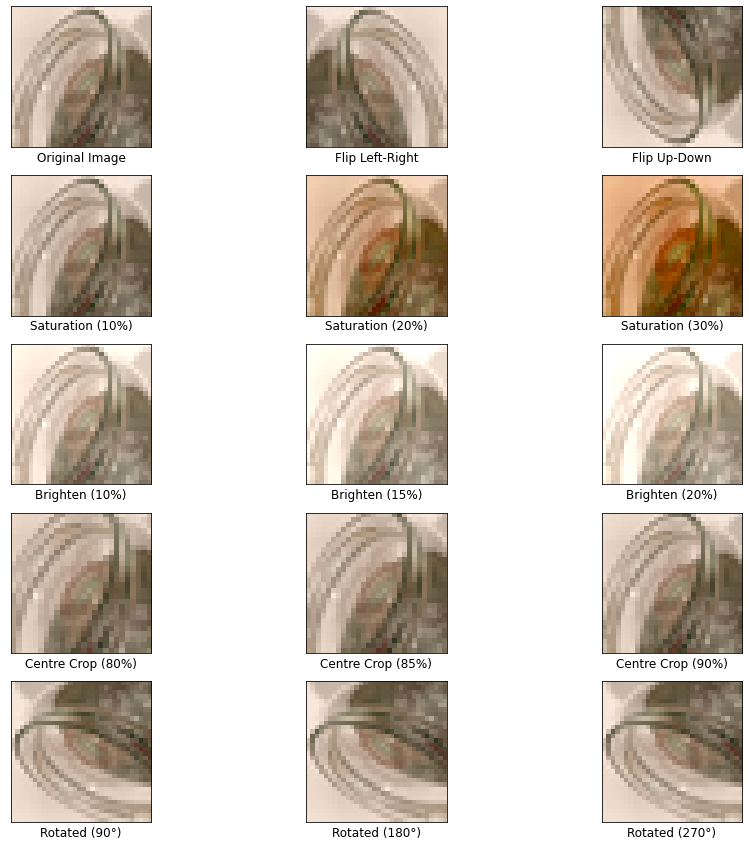

In [6]:
if optimisedModel: 
    newImages = []
    newLabels = []
    modifiedImageCounts = {}
    trainIn = np.asarray(trainIn)
    
    for count, currentImage in enumerate(trainIn):
       
        # Add current image
        newImages.append(currentImage)

        # Flip left-right, up-down
        newImages.append(tf.image.resize(tf.image.flip_left_right(currentImage), [32, 32]))
        newImages.append(tf.image.resize(tf.image.flip_up_down(currentImage), [32, 32]))

        # Add 10%, 20% or 30% saturation
        saturation = [1, 2, 3]
        random.shuffle(saturation)
        newImages.append(tf.image.resize(tf.image.adjust_saturation(currentImage, saturation[0]), [32, 32]))

        # Add 10%, 15% or 20% brightness
        brightness = [0.1, 0.15, 0.2]
        random.shuffle(brightness)
        newImages.append(tf.image.resize(tf.image.adjust_brightness(currentImage, brightness[0]), [32, 32]))

        # Central crop by 80%, 85% or 90%
        centralCrop = [0.8, 0.85, 0.9]
        random.shuffle(centralCrop)
        newImages.append(tf.image.resize(tf.image.central_crop(currentImage, central_fraction=centralCrop[0]), [32, 32]))

        # Add 90, 180 and 270 degree rotation
        rotated90 = tf.image.resize(tf.image.rot90(currentImage), [32, 32]) # 90
        rotated180 = tf.image.resize(tf.image.rot90(rotated90), [32, 32]) # 180
        rotated270 = tf.image.resize(tf.image.rot90(rotated180), [32, 32]) # 270

        degreeSelection = [rotated90, rotated180, rotated270]
        random.shuffle(degreeSelection)

        newImages.append(degreeSelection[0])

        # Append new labels
        for _ in range(7):
            newLabels.append(trainOut[count])

            # Add counts to the modifiedImageCounts            
            modifiedImageCounts[trainOut[count]] = modifiedImageCounts.get(trainOut[count], 0) + 1

        if count == 0:
            filterDict = {'Original Image' : currentImage,
                          'Flip Left-Right' : tf.image.flip_left_right(currentImage),
                          'Flip Up-Down' : tf.image.flip_up_down(currentImage), 
                          'Saturation (10%)' : tf.image.adjust_saturation(currentImage, 1), 
                          'Saturation (20%)' : tf.image.adjust_saturation(currentImage, 2), 
                          'Saturation (30%)' : tf.image.adjust_saturation(currentImage, 3), 
                          'Brighten (10%)' : tf.image.adjust_brightness(currentImage, 0.1),
                          'Brighten (15%)' : tf.image.adjust_brightness(currentImage, 0.15), 
                          'Brighten (20%)' : tf.image.adjust_brightness(currentImage, 0.20), 
                          'Centre Crop (80%)' : tf.image.central_crop(currentImage, central_fraction=0.8), 
                          'Centre Crop (85%)' : tf.image.central_crop(currentImage, central_fraction=0.85), 
                          'Centre Crop (90%)' : tf.image.central_crop(currentImage, central_fraction=0.9), 
                          'Rotated (90°)' : rotated90, 
                          'Rotated (180°)' : rotated90, 
                          'Rotated (270°)' : rotated90, 
                    }
            
            plt.figure(figsize=(15,15))
            
            for i, appliedFilter in enumerate(filterDict):
                plt.subplot(5,3,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(filterDict[appliedFilter])
                plt.xlabel(appliedFilter, fontsize=12)
            plt.show()
            
    # Assign the training dataset with augmented images and add new labels
    trainIn = newImages
    trainOut = newLabels

In [7]:
if optimisedModel:
    # Shuffle the training dataset but shuffle in same way to preserve output
    shuffled = list(zip(trainIn, trainOut))
    random.shuffle(shuffled)
    trainIn, trainOut = zip(*shuffled)

# (3) Verifying the dataset was processed correctly 

### Plot 5 images from the dataset


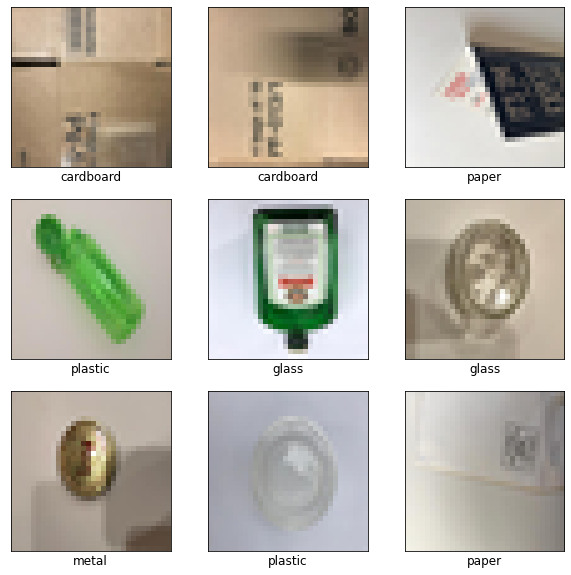

In [8]:
classDict = {0:'cardboard', 1:'glass', 2:'metal', 3:'paper', 4:'plastic', 5:'trash'}

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(trainIn[i]))
    plt.xlabel(classDict[trainOut[i]], fontsize=12)
plt.show()

### Plot the number of categories in the image augmented dataset

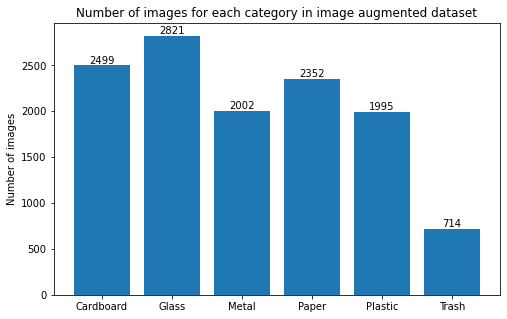

In [9]:
if optimisedModel: 
    assert(sum(modifiedImageCounts.values()) == len(trainIn))
    assert(len(trainIn) == len(trainOut))

    # Check numberings 
    fig = plt.figure(figsize=(8, 5))
    categories = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
    plt.bar(categories, list(modifiedImageCounts.values()))
    locs, _ = plt.xticks()
    
    # Add actual number above the bar
    for count, value in enumerate(modifiedImageCounts.values()):
        plt.text(count, value, value, ha="center", va="bottom")

    plt.title('Number of images for each category in image augmented dataset')
    plt.ylabel('Number of images')
    plt.show()

# (4) Building the model

### Add layers to create the CNN model

In [10]:
if optimisedModel:
    # CNN with dropout to help prevent overfitting    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Dropout(0.45))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.45))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='sigmoid'))
    #model.add(layers.Dropout(0.25))
    model.add(layers.Dense(6))
    
else: 
    # CNN without dropout
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(6))
    
# Display a summary of the model    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 64)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

### Compile the model and then train

In [11]:
# Compile and fit the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(np.array(trainIn), np.array(trainOut), epochs=20, validation_split=0.15)

Epoch 1/20
329/329 [==============================] - 8s 24ms/step - loss: 1.5043 - accuracy: 0.3865 - val_loss: 1.5104 - val_accuracy: 0.3907
Epoch 2/20
329/329 [==============================] - 8s 24ms/step - loss: 1.2833 - accuracy: 0.5000 - val_loss: 1.2522 - val_accuracy: 0.5210
Epoch 3/20
329/329 [==============================] - 8s 24ms/step - loss: 1.1615 - accuracy: 0.5616 - val_loss: 1.1498 - val_accuracy: 0.5662
Epoch 4/20
329/329 [==============================] - 8s 24ms/step - loss: 1.0905 - accuracy: 0.5867 - val_loss: 1.1030 - val_accuracy: 0.5727
Epoch 5/20
329/329 [==============================] - 8s 24ms/step - loss: 1.0155 - accuracy: 0.6227 - val_loss: 1.0121 - val_accuracy: 0.6189
Epoch 6/20
329/329 [==============================] - 9s 26ms/step - loss: 0.9832 - accuracy: 0.6328 - val_loss: 0.9608 - val_accuracy: 0.6475
Epoch 7/20
329/329 [==============================] - 8s 25ms/step - loss: 0.9051 - accuracy: 0.6597 - val_loss: 1.0012 - val_accuracy: 0.6173

# (5) Evaluating the model

### Accuracy vs Validation Accuracy Plot

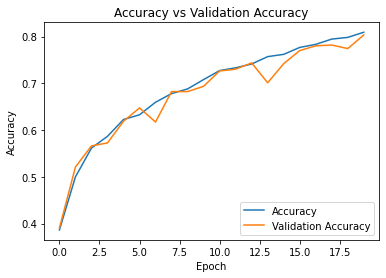

In [12]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label ='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### Loss vs Validation Loss Accuracy Plot

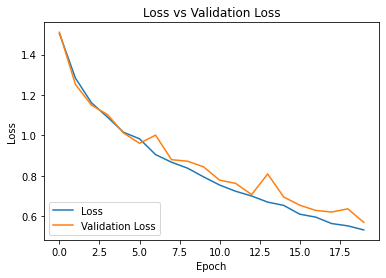

In [13]:
### Loss vs Validation Loss Accuracy
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Validation Loss')
plt.legend(loc='lower left')
plt.show()

### Evaluate performance on the testing set

In [14]:
test_loss, test_acc = model.evaluate(np.asarray(testIn), np.asarray(testOut), verbose=0)

print("Testing Accuracy: {:.4f}".format(test_acc))
print("Testing Loss: {:.4f}".format(test_loss))

Testing Accuracy: 0.7427
Testing Loss: 0.7565


### Predict with my own dataset

In [15]:
predictedImages = []
highresImages = []
predictedLabels = []

for count, (image, label) in enumerate(predictionDataset):
        predictedImages.append(image)
        highresImages.append(highResPredictionDataset[count])
        predictedLabels.append(label)

predictions = model.predict(np.array(predictedImages))
results = []

for count, prediction in enumerate(predictions):
    # Predicted, Actual
    results.append((classDict[np.argmax(prediction)], predictedLabels[count]))

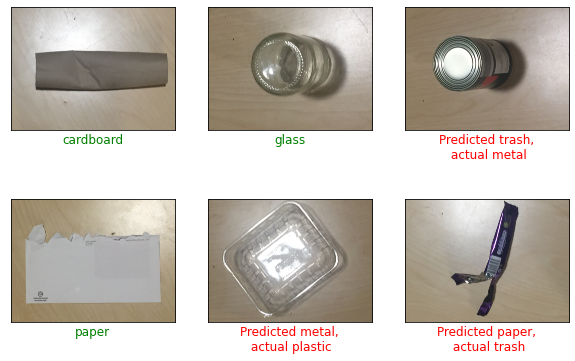

Number predicted correctly: 3


In [16]:
correctCount = 0
plt.figure(figsize=(10,10))

for i, (predicted, actual) in enumerate(results):
    ax = plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(highresImages[i])
    
    if predicted == actual:
        ax.xaxis.label.set_color('green')
        plt.xlabel(predicted, fontsize=12)
        correctCount += 1
    else: 
        ax.xaxis.label.set_color('red')
        plt.xlabel("Predicted " + predicted + ",\n actual " + actual, fontsize=12)
    
plt.show()

print("Number predicted correctly:", correctCount)